In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor

In [2]:
def r2_oos(y_true, y_pred, sample_weight=None):
    if sample_weight is not None:
        weight = sample_weight[:, np.newaxis]
    else:
        weight = 1.
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
                                                      dtype=np.float64)
    denominator = (weight * (y_true) ** 2).sum(axis=0,
                                                    dtype=np.float64)
   
    
    output_scores = 1 - (numerator / denominator)

    return output_scores

def recur_eval_dataset(dataset, year_start, year_stop):
    n = year_start + 12
    while n <= year_stop:
        train = dataset[dataset['DATE'] < year_start * 10000 + 101]
        vali = dataset[(dataset['DATE'] < n * 10000 + 101) & (dataset['DATE'] > year_start * 10000 + 101)]
        test = dataset[(dataset['DATE'] < (n + 1) * 10000 + 101) & (dataset['DATE'] > n * 10000 + 101)]
        yield train, vali, test
        year_start += 1
        n = year_start + 12

In [5]:
df = pd.read_csv('1957_2016.csv')
df = df.iloc[:, 2:]
df.dropna(inplace=True)
df.shape

(979422, 100)

In [6]:
from numpy import mean
score = []
imp = 0
for train, vali, test in recur_eval_dataset(df, 1975, 1987):
    x = train.iloc[:, 1:].drop(columns='RET')
    y = train.iloc[:, 2]
    model = RandomForestRegressor()
    model.fit(x, y)
    val_x = vali.iloc[:, 1:].drop(columns='RET')
    val_y = vali.iloc[:, 2]
    predict_val = model.predict(val_x)
    print('---------')
    r2_oos(val_y.values, predict_val)
    test_x = test.iloc[:, 1:].drop(columns='RET')
    test_y = test.iloc[:, 2]
    predict_test = model.predict(test_x)
    score.append(r2_oos(test_y.values, predict_test))
    imp = model.feature_importances_
mean(score)

RandomForestRegressor()

---------


0.7488367922175906

0.6775929073450506

In [11]:
X = df.iloc[:, 1:].drop(columns='RET').columns

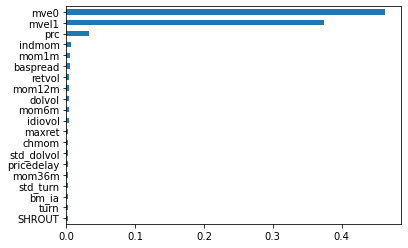

In [14]:
feat_importances = pd.Series(imp, index=X)
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()